# Exercise 4: Deep Neural Networks in OpenCV

As a first step, let's import the python modules we need.

In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

OpenCV contains a module [cv.dnn](https://docs.opencv.org/4.5.2/d6/d0f/group__dnn.html) that can be used for carrying-out inference of pre-trained *deep neural networks*. The module can load and use pre-trained models from the following deep learning frameworks:
- [TensorFlow](https://www.tensorflow.org)
- [Torch](http://torch.ch)
- [Caffe](http://caffe.berkeleyvision.org)
- [Darknet](https://pjreddie.com/darknet)
- [Open Neural Network Exchnage (ONNX)](https://onnx.ai)

Open Neural Network Exchnage (ONNX) isn't really a deep learning framework, but a an open model format, used to share deep neural network models between frameworks, i.e. you can convert any framework model to the ONNX format, and most frameworks can load an ONNX model.

The OpenCV Deep Neural Network module provides functions to load models from each framework:
- `cv.dnn.readNetFromTensorflow()`
- `cv.dnn.readNetFromTorch()`
- `cv.dnn.readNetFromCaffe()`
- `cv.dnn.readNetFromDarknet()`
- `cv.dnn.readNetFromONNX()`

All functions take different arguments, and all functions (except for `cv.dnn.readNetFromTorch()`) come in two overloaded versions, where one overloaded function loads a model file from the file system, and the other takes a model *buffer* as input (`cv.dnn.readNetFromTorch()` can only load a model from the file system).

Let's look at the *docstring* for `cv.dnn.readNetFromTensorflow()` below:

In [16]:
cv.dnn.readNetFromTensorflow?

Docstring:
readNetFromTensorflow(model[, config]) -> retval
.   @brief Reads a network model stored in <a href="https://www.tensorflow.org/">TensorFlow</a> framework's format.
.         * @param model  path to the .pb file with binary protobuf description of the network architecture
.         * @param config path to the .pbtxt file that contains text graph definition in protobuf format.
.         *               Resulting Net object is built by text graph using weights from a binary one that
.         *               let us make it more flexible.
.         * @returns Net object.



readNetFromTensorflow(bufferModel[, bufferConfig]) -> retval
.   @brief Reads a network model stored in <a href="https://www.tensorflow.org/">TensorFlow</a> framework's format.
.         * @param bufferModel buffer containing the content of the pb file
.         * @param bufferConfig buffer containing the content of the pbtxt file
.         * @returns Net object.
Type:      builtin_function_or_method


From the *docstring* above, we can see that the first overloaded version of the function has the following signature:

`readNetFromTensorflow(model[, config]) -> retval`
- `model` is the path to a TensorFlow binary *protobuf* file (.pb) that contains the network architecture and weights.
- `config` is the path to a file containing the textual representation of the network architecture.

The function returns `retval` containing an instance of the class [Net](https://docs.opencv.org/4.5.2/db/d30/classcv_1_1dnn_1_1Net.html). Unfortunately, the OpenCV developers have not implemented support for the TensorFlow 2.0 file format yet (the [SavedModel](https://www.tensorflow.org/guide/saved_model) format), i.e. it can only load saved models in the older TensorFlow 1.1 *frozen graph* format (also with a .pb extension, but also requires the textual representation with a .pbtxt extension). Unfortunately, converting a Tensorflow 2 model to ONNX, and loading it into OpenCV will also fail, at the moment. We'll have to wait until the OpenCV developers fix this in a later version of OpenCV. Otherwise, a Tensorflow and Keras model can be converted into the ONNX format using [tf2onnx](https://github.com/onnx/tensorflow-onnx) and [keras2onnx](https://github.com/onnx/keras-onnx) respectively.

But, let's look at a few examples of loading and using pre-existing models (other than Tensorflow 2) for inference, so you know how to use the DNN module in OpenCV.

To be honest, loading models from other frameworks is also a bit messy at the moment, and by that I mean it's a bit of a hassle to find all the files needed to run a certain model. There is a good introduction to this [here](https://bleedai.com/deep-learning-with-opencv-dnn-module-a-comprehensive-guide) that you can read to get started.

## Classification
### Caffe GoogleNet

Let's start with a simple deep learning model for *image classification*. A popular dataset for training classification models is the `ImageNet` dataset, that contains millions of images and 1000 classes. Tensorflow actually has a lot of datasets available via their API, which you can find [here](https://www.tensorflow.org/datasets/catalog/overview). We don't need the dataset if we are just going to run inference with a pre-trained model. We just need the class labels, which can be found in file `synset_words.txt`. Let's load this file and store the class names in the variable `classes`.

In [17]:
# Load the class labels from disk
rows = open('../models/caffe/synset_words.txt').read().strip().split("\n")
classes = [r[r.find(" ") + 1:].split(",")[0] for r in rows]

print(f'Number of classes: {len(classes)}')
print(f'The first 5 classes: {classes[:5]}')

Number of classes: 1000
The first 5 classes: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']


Let's also load a test image that we want to classify.

In [18]:
# load the input image from disk
image = cv.imread('../data/eagle.png')

Before we can classify an image using OpenCV's DNN module, we need to convert the image into a, so called, `blob`. This is done with OpenCV's function [cv.dnn.blobFromImage()](https://docs.opencv.org/master/d6/d0f/group__dnn.html), with the following signature.

In [19]:
cv.dnn.blobFromImage?

Docstring:
blobFromImage(image[, scalefactor[, size[, mean[, swapRB[, crop[, ddepth]]]]]]) -> retval
.   @brief Creates 4-dimensional blob from image. Optionally resizes and crops @p image from center,
.        *  subtract @p mean values, scales values by @p scalefactor, swap Blue and Red channels.
.        *  @param image input image (with 1-, 3- or 4-channels).
.        *  @param size spatial size for output image
.        *  @param mean scalar with mean values which are subtracted from channels. Values are intended
.        *  to be in (mean-R, mean-G, mean-B) order if @p image has BGR ordering and @p swapRB is true.
.        *  @param scalefactor multiplier for @p image values.
.        *  @param swapRB flag which indicates that swap first and last channels
.        *  in 3-channel image is necessary.
.        *  @param crop flag which indicates whether image will be cropped after resize or not
.        *  @param ddepth Depth of output blob. Choose CV_32F or CV_8U.
.        *  @det

From the signature above, we see that we can provide numerous parameters, in addition to the image as the first input parameter. Once again, this is quite messy with OpenCV's DNN module. We need to hunt around again for these additional parameters. Once again, see this [article](https://bleedai.com/deep-learning-with-opencv-dnn-module-a-comprehensive-guide) for more information. The additional parameters we need in this case is the `scalefactor`, `size` and `mean`. The `scalefactor` is just 1 in this case, and we need to set the `size` to the same image size used when training the model. In this cases we need to re-scale the image to 244 x 244 pixels. Finally, we need to provide the `mean` value of each color channel from the training dataset. In this case, we need to set this to (104, 117, 123).

In [20]:
# Our CNN requires fixed spatial dimensions for our input image(s)
# so we need to ensure it is resized to 224x224 pixels while
# performing mean subtraction (104, 117, 123) to normalize the input.
# After executing this command our "blob" has the shape: (1, 3, 224, 224),
# where 3 is for the three color channels, and (244, 244) is the height and width.
blob = cv.dnn.blobFromImage(image, 1, (224, 224), (104, 117, 123))

print(f'blob.shape: {blob.shape}')

blob.shape: (1, 3, 224, 224)


Next, we load the pre-trained model from disk. We are using a model called *GoogleNet*, trained using the *Caffe* deep learning framework. Therefore, we need to use the function `cv.dnn.readNetFromCaffe()`, and supply two Caffe-specific files as input parameters (with the file extensions .prototxt and .caffemodel). The function returns an instance of the class [Net](https://docs.opencv.org/4.5.2/db/d30/classcv_1_1dnn_1_1Net.html).

In [21]:
# load our serialized model from disk
net = cv.dnn.readNetFromCaffe('../models/caffe/bvlc_googlenet.prototxt', '../models/caffe/bvlc_googlenet.caffemodel')

Next, we use invoke the function `setInput()` on the instance of the returned [Net](https://docs.opencv.org/4.5.2/db/d30/classcv_1_1dnn_1_1Net.html), and supply the image *blob* as an input parameter. This tells the pre-trained network which image *blob* we want to classify. Then we call the function `forward()` on the [Net](https://docs.opencv.org/4.5.2/db/d30/classcv_1_1dnn_1_1Net.html) instance to pas the image through the model, which returns the class predictions.

In [24]:
# Set the blob as input to the network
net.setInput(blob)

# Run the model in the forward direction to get the class predictions.
preds = net.forward()

Finally, we sort the returned predictions in descending order of probability, grab the top 5 predictions, and print out the result, along with a plot of the image. We see that the pre-trained GoogleNet model managed to predict the correct class with very high accuracy.

[INFO] 1. label: bald eagle, probability: 0.99997
[INFO] 2. label: kite, probability: 3.4535e-05
[INFO] 3. label: vulture, probability: 1.6599e-07
[INFO] 4. label: hornbill, probability: 2.8287e-08
[INFO] 5. label: albatross, probability: 2.4403e-08


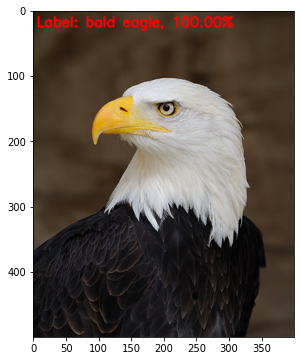

In [25]:
# Sort the indexes of the probabilities in descending order (higher
# probabilitiy first) and grab the top-5 predictions
idxs = np.argsort(preds[0])[::-1][:5]

# Loop over the top-5 predictions and display them
for (i, idx) in enumerate(idxs):
	# Draw the top prediction on the input image
	if i == 0:
		text = "Label: {}, {:.2f}%".format(classes[idx], preds[0][idx] * 100)
		cv.putText(image, text, (5, 25),  cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
	# Display the predicted label + associated probability to the console	
	print("[INFO] {}. label: {}, probability: {:.5}".format(i + 1, classes[idx], preds[0][idx]))

# Display the output image
plt.figure(figsize=(6,6))
plt.imshow(image[:,:,::-1])
plt.show()

## Object Detection

### Caffe MobileNet SSD

The next model was also trained using the Caffe deep learning framework, but uses a `MobileNet SSD` model (where SSD stands for *Single Shot Detector*). This is a object detection model, trained on the COCO dataset (an image dataset with labels and* ground truth* bounding boxes). We won't explore this code in detail, since we will mostly be using TensorFlow Lite models directly for our deep learning models. Read the comments in the code, to get an understanding of what's going on. This example loads a video file, and detects objects in each frame.

In [26]:
# Minimum probability to filter weak detections
confidence_threshold = 0.2 

# Initialize the list of class labels MobileNet SSD was trained to
# detect, then generate a set of bounding box colors for each class
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# Load our serialized model from disk
net = cv.dnn.readNetFromCaffe('../models/caffe/MobileNetSSD_deploy.prototxt', '../models/caffe/MobileNetSSD_deploy.caffemodel')

# Initialize the video stream
vs = cv.VideoCapture('../data/street_traffic_360.mp4')

# Loop over the frames from the video stream
while vs.isOpened():
	# Read the next frame from the file
	(grabbed, frame) = vs.read()

	# If grabbed=False, we have reached the end of the stream
	if not grabbed:
		break

	# Resize the frame
	(h, w) = frame.shape[:2]
	scale_factor = 800 / w # we want width=800, and want to keep the aspect ratio
	dim = (int(w * scale_factor), int(h * scale_factor))
	frame = cv.resize(frame, dim, interpolation = cv.INTER_AREA)
	
	# Grab the new frame dimensions
	(h, w) = frame.shape[:2]
	
	# Convert the frame to a blob
	blob = cv.dnn.blobFromImage(frame, 0.007843, (300, 300), 127.5)

	# Pass the blob through the network and obtain the detections and predictions
	net.setInput(blob)
	detections = net.forward()

	# Loop over the detections
	for i in np.arange(0, detections.shape[2]):
		# Extract the confidence (i.e., probability) associated with the prediction
		confidence = detections[0, 0, i, 2]

		# Filter out weak detections by ensuring the `confidence` is
		# greater than the minimum confidence
		if confidence > confidence_threshold:
			# Extract the index of the class label from the
			# `detections`, then compute the (x, y)-coordinates of
			# the bounding box for the object
			idx = int(detections[0, 0, i, 1])
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# Draw the prediction on the frame
			label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
			cv.rectangle(frame, (startX, startY), (endX, endY), COLORS[idx], 2)
			y = startY - 15 if startY - 15 > 15 else startY + 15
			cv.putText(frame, label, (startX, y), cv.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

	# Show the output frame
	cv.imshow("Frame", frame)
	key = cv.waitKey(1) & 0xFF

	# If the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# Release the VideoCapture and destroy any windows we created
vs.release()
cv.destroyAllWindows()

## Object Detection
### [Darknet](https://pjreddie.com/darknet) YOLO V3

Here another example of object detection using a YOLO V3 model, trained using the Darknet deep learning framework. Once again, we won't explore this code in detail, since we will mostly be using TensorFlow Lite models directly for our deep learning models. Read the comments in the code, to get an understanding of what's going on. This example loads another video file, and detects objects in each frame.

In [27]:
# Minimum probability to filter weak detections
confidence_threshold = 0.5 

# Threshold when applyong non-maxima suppression
nms_threshold = 0.3 

# Load the COCO class labels our YOLO model was trained on
LABELS = open('../models/darknet/coco.names').read().strip().split("\n")

# Initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# Load our YOLO object detector trained on the COCO dataset (80 classes)
net = cv.dnn.readNetFromDarknet('../models/darknet/yolov3.cfg', '../models/darknet/yolov3.weights')

# Determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Initialize the width and height of the frames in the video file
W = None
H = None

# Initialize the video stream
vs = cv.VideoCapture('../data/street_traffic_360.mp4')

# Loop over frames from the video file stream
while vs.isOpened():
	# Read the next frame from the file
	(grabbed, frame) = vs.read()

	# If grabbed=False, we have reached the end of the stream
	if not grabbed:
		break

	# If the frame dimensions are empty, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]

	# Construct a blob from the input frame and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes
	# and associated probabilities
	blob = cv.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
	net.setInput(blob)
	layerOutputs = net.forward(ln)

	# Initialize our lists of detected bounding boxes,
	# confidences, and class IDs, respectively
	boxes = []
	confidences = []
	classIDs = []

	# Loop over each of the layer outputs
	for output in layerOutputs:
		# Loop over each of the detections
		for detection in output:
			# Extract the class ID and confidence (i.e., probability)
			# of the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# Filter out weak predictions by ensuring the detected
			# probability is greater than the minimum probability
			if confidence > confidence_threshold:
				# Scale the bounding box coordinates back relative to
				# the size of the image, keeping in mind that YOLO
				# actually returns the center (x, y)-coordinates of
				# the bounding box followed by the boxes' width and
				# height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")

				# Use the center (x, y)-coordinates to derive the top
				# and and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))

				# Update our list of bounding box coordinates,
				# confidences, and class IDs
				boxes.append([x, y, int(width), int(height)])
				confidences.append(float(confidence))
				classIDs.append(classID)

	# Apply non-maximum suppression to suppress weak, overlapping bounding boxes
	idxs = cv.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

	# Ensure that at least one detection exists
	if len(idxs) > 0:
		# Loop over the indexes we are keeping
		for i in idxs.flatten():
			# Extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])

			# Draw a bounding box rectangle and label on the frame
			color = [int(c) for c in COLORS[classIDs[i]]]
			cv.rectangle(frame, (x, y), (x + w, y + h), color, 2)
			text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
			cv.putText(frame, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

	# show the output frame
	cv.imshow("Frame", frame)
	key = cv.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# Release the VideoCapture and destroy any windows we created
vs.release()
cv.destroyAllWindows()

## Object Detection and Segmentation
### Tensorflow Mask R-CNN

In this last example, we are using a Mask R-CNN model, trained using the Tensorflow (Tensorflow 1) deep learning framework. Since we are using a Mask R-CNN model, we can detect objects and do image segmentation at the same time. Once again, we won't explore this code in detail, since we will mostly be using TensorFlow Lite models directly for our deep learning models. Read the comments in the code, to get an understanding of what's going on. This example loads another video file, then detects and segments objects in each frame.

In [28]:
# Minimum probability to filter weak detections
confidence_threshold = 0.5 

# Minimum threshold for pixel-wise mask segmentation
pwms_threshold = 0.3 

# Load the COCO class labels our Mask R-CNN was trained on
LABELS = open('../models/tensorflow/object_detection_classes_coco.txt').read().strip().split("\n")

# Initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# Load our Mask R-CNN trained on the COCO dataset (90 classes) from disk
net = cv.dnn.readNetFromTensorflow('../models/tensorflow/frozen_inference_graph.pb', '../models/tensorflow/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt')

# Initialize the video stream
vs = cv.VideoCapture('../data/street_traffic_360.mp4')

# Loop over the frames from the video file stream
while vs.isOpened():
	# Read the next frame from the file
	(grabbed, frame) = vs.read()

	# If grabbed=false, we have reached the end of the stream
	if not grabbed:
		break

	# Construct a blob from the input frame and then perform a
	# forward pass of the Mask R-CNN, giving us (1) the bounding box
	# coordinates of the objects in the image along with (2) the
	# pixel-wise segmentation for each specific object
	blob = cv.dnn.blobFromImage(frame, swapRB=True, crop=False)
	net.setInput(blob)
	(boxes, masks) = net.forward(["detection_out_final", "detection_masks"])

	# Loop over the number of detected objects
	for i in range(0, boxes.shape[2]):
		# Extract the class ID of the detection along with the
		# confidence (i.e., probability) associated with the
		# prediction
		classID = int(boxes[0, 0, i, 1])
		confidence = boxes[0, 0, i, 2]

		# Filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > confidence_threshold:
			# Scale the bounding box coordinates back relative to the
			# size of the frame and then compute the width and the
			# height of the bounding box
			(H, W) = frame.shape[:2]
			box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
			(startX, startY, endX, endY) = box.astype("int")
			boxW = endX - startX
			boxH = endY - startY

			# Extract the pixel-wise segmentation for the object,
			# resize the mask such that it's the same dimensions of
			# the bounding box, and then finally threshold to create
			# a *binary* mask
			mask = masks[i, classID]
			mask = cv.resize(mask, (boxW, boxH), interpolation=cv.INTER_CUBIC)
			mask = (mask > pwms_threshold)

			# Extract the ROI of the image but *only* extracted the
			# masked region of the ROI
			roi = frame[startY:endY, startX:endX][mask]

			# Grab the color used to visualize this particular class,
			# then create a transparent overlay by blending the color
			# with the ROI
			color = COLORS[classID]
			blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")

			# Store the blended ROI in the original frame
			frame[startY:endY, startX:endX][mask] = blended

			# Draw the bounding box of the instance on the frame
			color = [int(c) for c in color]
			cv.rectangle(frame, (startX, startY), (endX, endY), color, 2)

			# Draw the predicted label and associated probability of
			# the instance segmentation on the frame
			text = "{}: {:.4f}".format(LABELS[classID], confidence)
			cv.putText(frame, text, (startX, startY - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

	# Show the output frame
	cv.imshow("Frame", frame)
	key = cv.waitKey(1) & 0xFF

	# If the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# Release the VideoCapture and destroy any widows we created
vs.release()
cv.destroyAllWindows()